In [1]:
import numpy as np
from sktime.performance_metrics.forecasting import (
    mean_squared_error,
    geometric_mean_squared_error,
)
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)
from sktime.forecasting.model_evaluation import evaluate

# Forecasters:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
# SARIMAX
from sktime.forecasting.sarimax import SARIMAX

from src.data import load_train_test
from src import get_config, plot_windows

In [2]:
# Cross-validation parameters:
WINDOW_LENGTH = 24 * 7 * 4 * 3
STEP_LENGTH = 24 * 7 * 4

WINDOW_LENGTH, STEP_LENGTH

(2016, 672)

In [3]:
config = get_config()
train, test = load_train_test(config.processed_data_path)

target_column = str(config.target_station_id)
train_target_series = train[target_column]
test_target_series = test[target_column]

X_train = train.drop(columns=[target_column])
X_test = test.drop(columns=[target_column])

In [6]:
forecasting_horizon = np.arange(1, 24 * 7 + 1)
cv = SlidingWindowSplitter(forecasting_horizon, WINDOW_LENGTH, STEP_LENGTH)

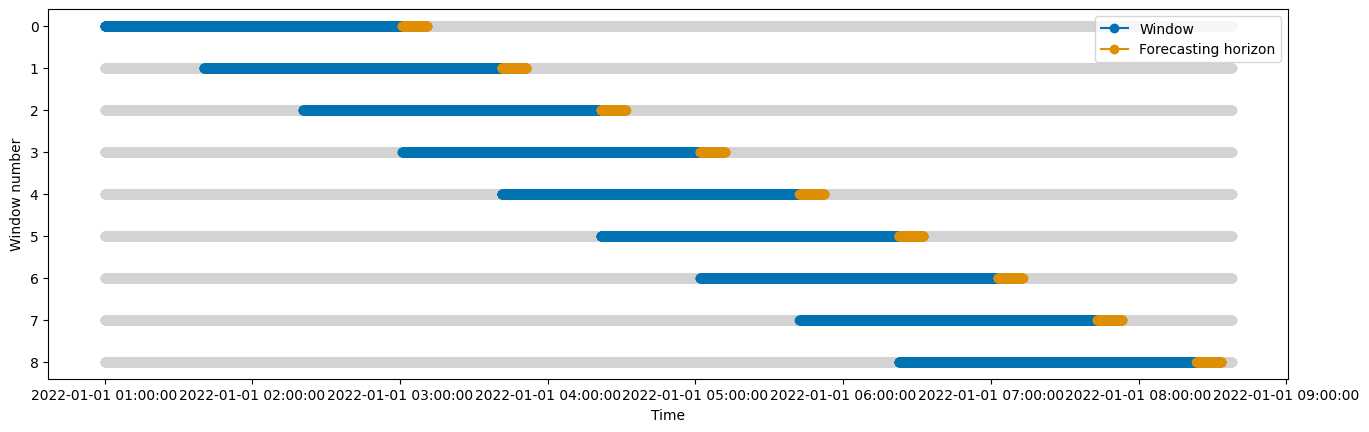

In [7]:
plot_windows(cv, train_target_series)

In [9]:
forecaster = MultiplexForecaster(
    [
        ("naive", NaiveForecaster(strategy="last", sp=24 * 7)),
        ("theta", ThetaForecaster(sp=24 * 7)),
        ("sarimax", SARIMAX(order=(1, 0, 50), seasonal_order=(2, 0, 0, 24 * 7))),
    ]
)

In [10]:
param_grid = {
    "selected_forecaster": ["naive", "theta", "ets"],
    # "naive__strategy": ["last", "mean", "drift"],
    # "theta__sp": [24, 24 * 7],
    # "ets__auto": [True, False],
    # "ets__sp": [24, 24 * 7],
}

gscv = ForecastingGridSearchCV(
    forecaster,
    cv=cv,
    param_grid=param_grid,
    scoring=geometric_mean_squared_error,
    n_jobs=-1,
    verbose=3,
)

In [11]:
gscv.fit(train_target_series, X_train)

Fitting 9 folds for each of 3 candidates, totalling 27 fits


/home/pablo/.cache/pypoetry/virtualenvs/src--eE-fv8V-py3.10/lib/python3.10/site-packages/sktime/utils/parallel.py:92: FitFailedWarning: 
                In evaluate, fitting of forecaster MultiplexForecaster failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 0-th data split, on training data y_train with
                cutoff <NA>, and len(y_train)=2016.
                The score will be set to nan.
                Failed forecaster with parameters: MultiplexForecaster(forecasters=[('naive', NaiveForecaster(sp=168)),
                                 ('theta', ThetaForecaster(sp=168)),
                                 ('ets', AutoETS(auto=True, sp=168))],
                    selected_forecaster='naive').
                
  ret = [fun(x, meta=meta) for x in iter]
/home/pablo/.cache/pypoetry/virtualenvs/src--eE-fv8V-py3.10/lib/python3.10/site-packages/sktime/utils/parallel.py:92: FitFailedWa

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100...
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168]),
                                                 step_length=672,
                                                 window_length=2016),
                        forecaster=MultiplexForecaster(forecasters=[('naive',
                                                                     NaiveForecaster(sp=168)),
                                                                    ('theta',
                                                                     ThetaForecaster(sp=168)),
                                                                    ('ets',
                                                                     AutoETS(auto=True,
                                                                             sp=168))]),
                        n_jobs=-1,
                        param_grid={'selected_forecaster': ['naive', 'theta',
                                                            'ets']},
                        scoring=<function geometric_mean_squared_error at 0x7fc7dafbf0a0>,
                        verbose=3)

In [12]:
gscv.best_params_

{'selected_forecaster': 'ets'}

In [13]:
gscv.best_score_

12.490642483825205

In [14]:
gscv.predict(forecasting_horizon, X_test)

2022-11-15 00:00:00     8.395251
2022-11-15 01:00:00     9.363222
2022-11-15 02:00:00    10.417413
2022-11-15 03:00:00    10.864523
2022-11-15 04:00:00    10.764945
                         ...    
2022-11-21 19:00:00     9.679611
2022-11-21 20:00:00     9.278459
2022-11-21 21:00:00     8.150770
2022-11-21 22:00:00     8.292663
2022-11-21 23:00:00     8.064407
Freq: H, Name: 90, Length: 168, dtype: float64